In [1]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
import pandas as pd


<Figure size 1440x1440 with 0 Axes>

# Train with 100 sample 

# Generate Mel Spectogram

In [3]:
DataPath = "../../DataSets/FinalDataSet/clips/"

In [7]:
Dataset = pd.read_csv("Test10.csv")
Dataset.drop("Unnamed: 0", axis=1, inplace=True)

In [10]:
Dataset

filename                 speaker language    length gender  \
0      en-n-490-8-VF.wav      anonymous-20090116       en  3.750000      n   
1      en-n-625-7-VF.wav      anonymous-20090530       en  4.010688      n   
2   en-n-2803-230-VF.wav     chocoholic-20080420       en  5.720000      n   
3     en-n-2761-7-VF.wav  catchercradle-20130202       en  5.500000      n   
4     en-n-5164-3-VF.wav          robin-20030302       en  5.973375      n   
..                   ...                     ...      ...       ...    ...   
65     fr-n-936-7-VF.wav        Fao10rk-20151220       fr  8.000000      n   
66     fr-n-275-6-VF.wav      anonymous-20130423       fr  4.875000      n   
67     fr-n-495-7-VF.wav          arbae-20141016       fr  7.750000      n   
68     fr-n-360-9-VF.wav      anonymous-20150329       fr  5.125000      n   
69    fr-n-1369-8-VF.wav         locked-20081022       fr  5.500000      n   

    accent datasetname  
0      NaN          VF  
1      NaN          VF  
2      NaN          VF  
3      NaN          VF  
4      NaN          VF  
..     ...         ...  
65     NaN          VF  
66     NaN          VF  
67     NaN          VF  
68     NaN          VF  
69     NaN          VF  

[70 rows x 7 columns]

C:\Users\mm\AppData\Local\Temp\ipykernel_11220\2864982420.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


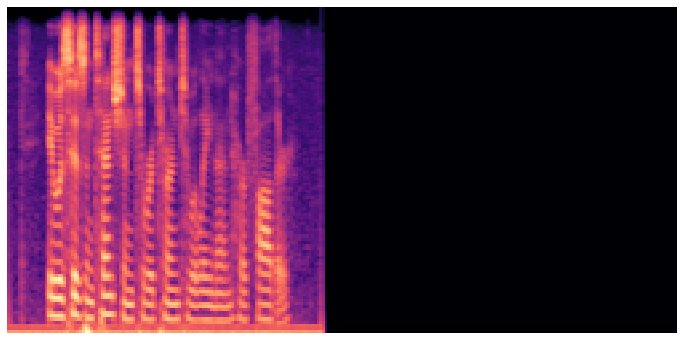

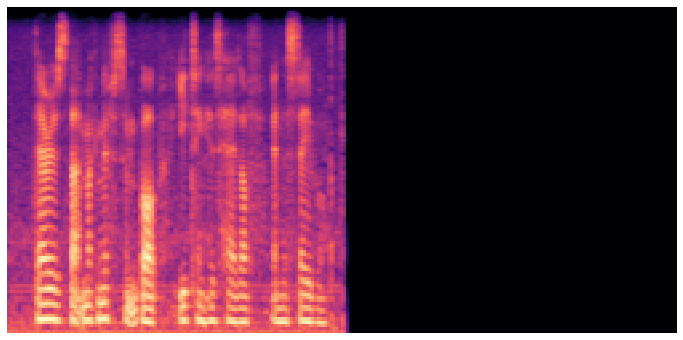

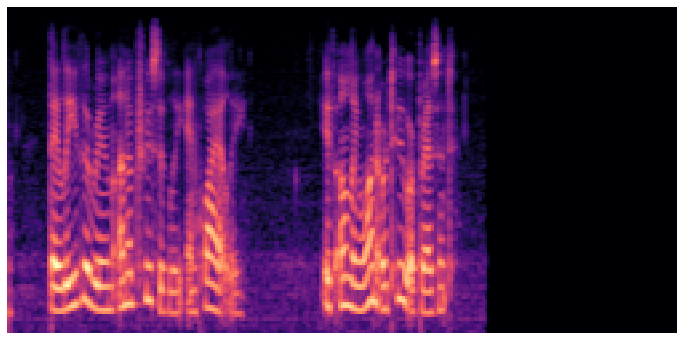

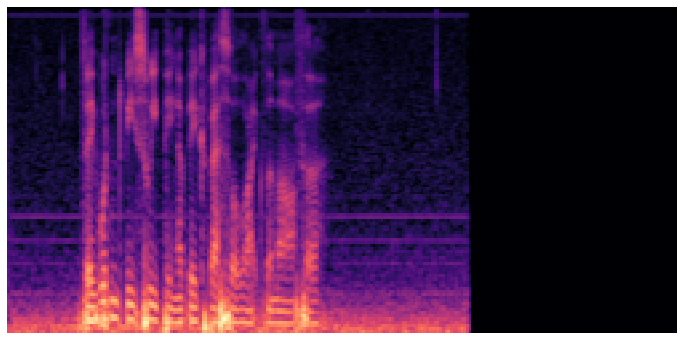

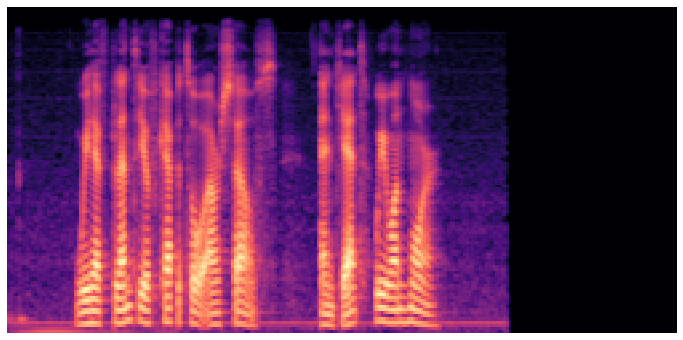

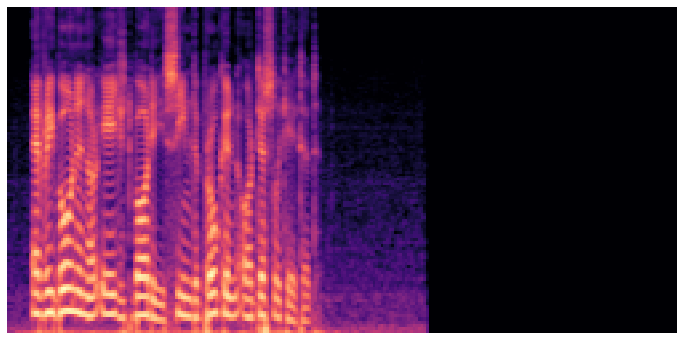

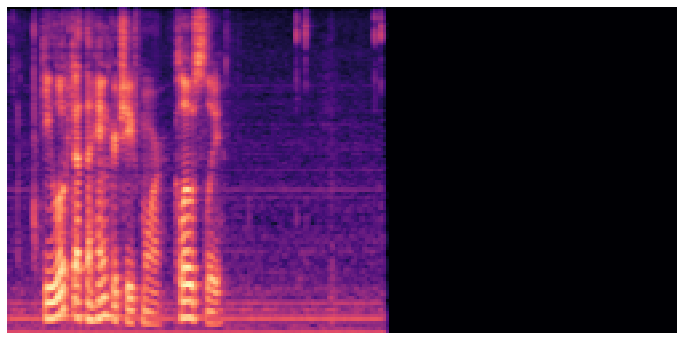

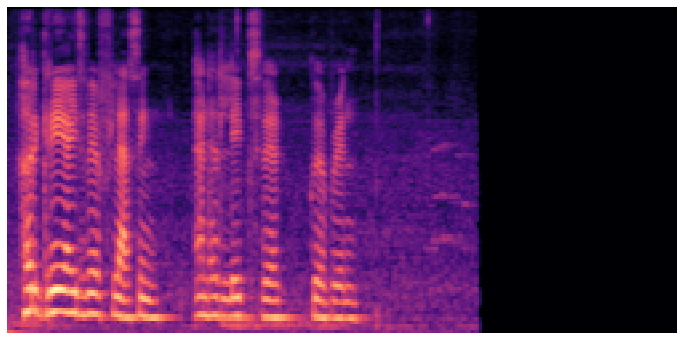

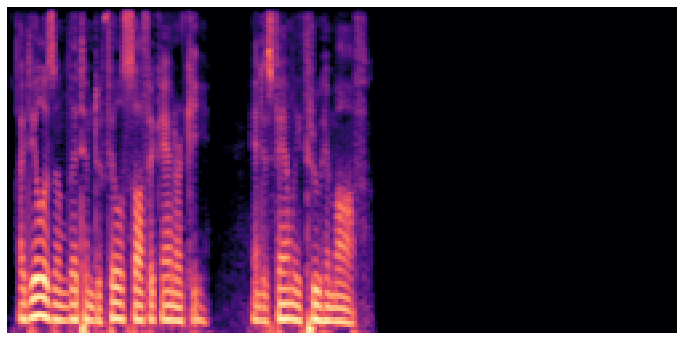

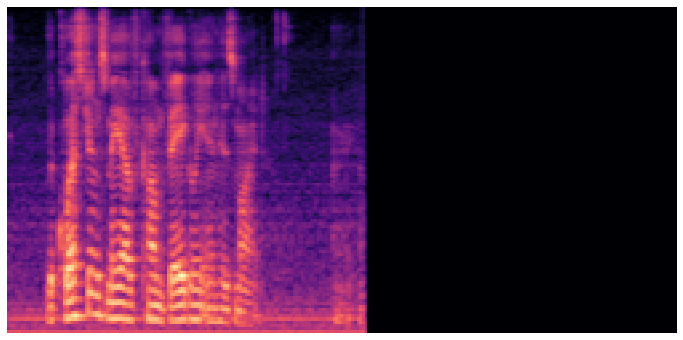

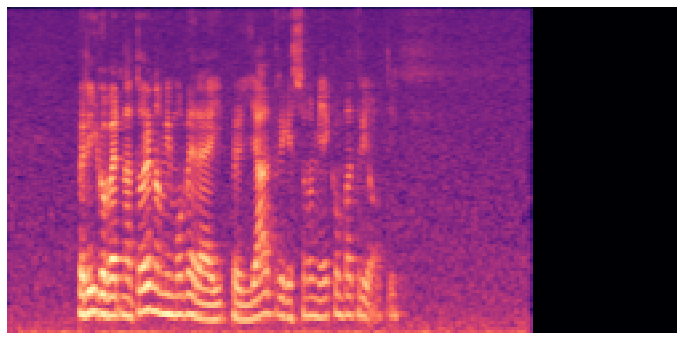

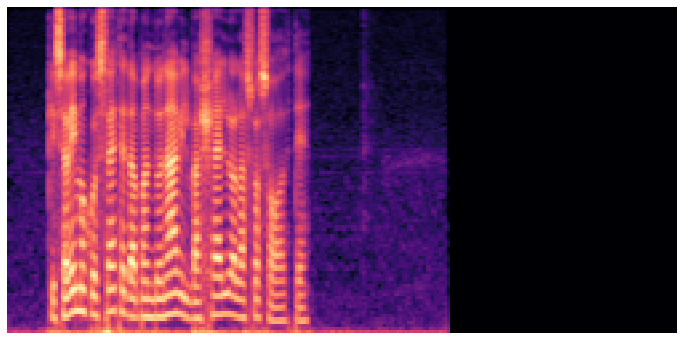

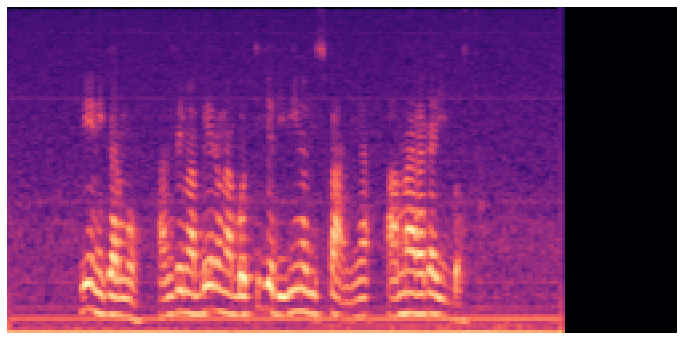

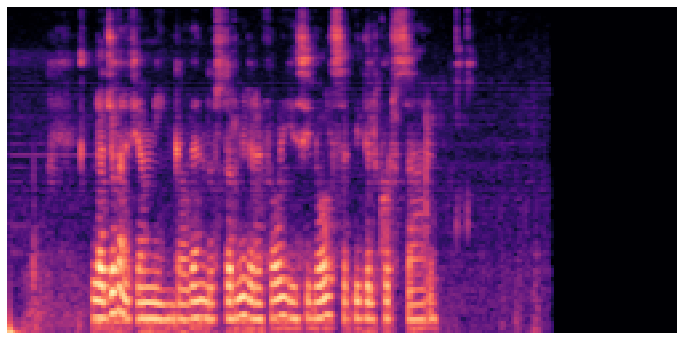

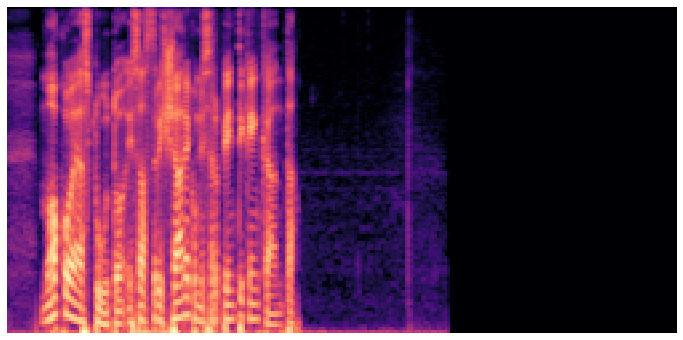

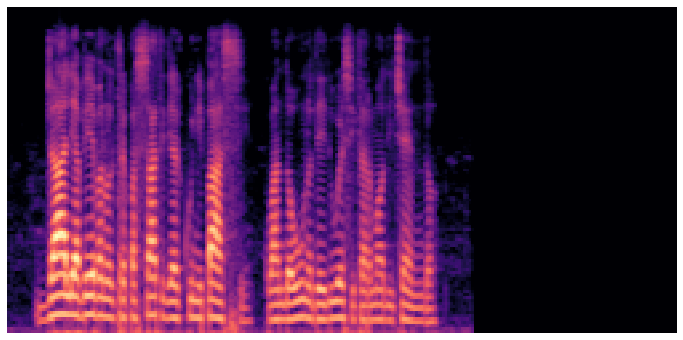

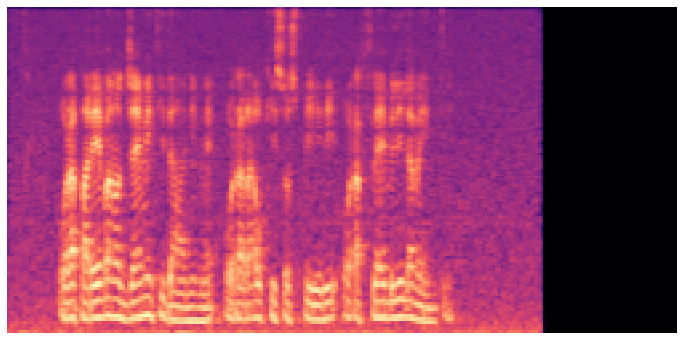

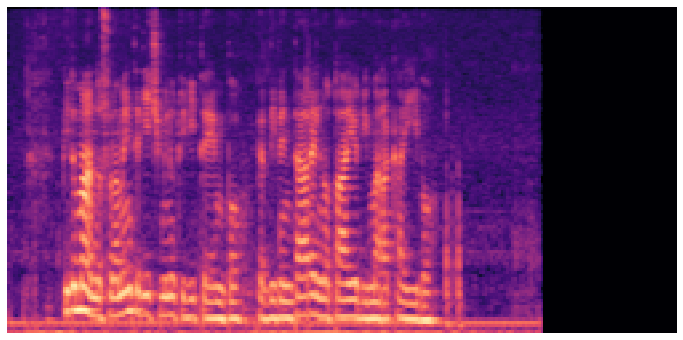

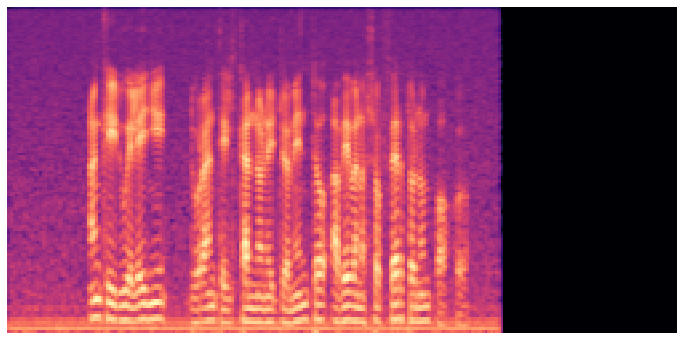

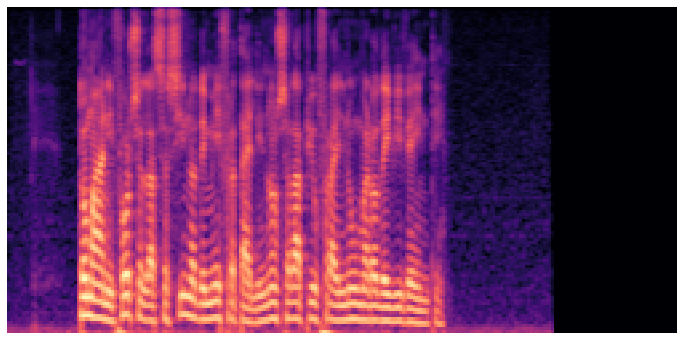

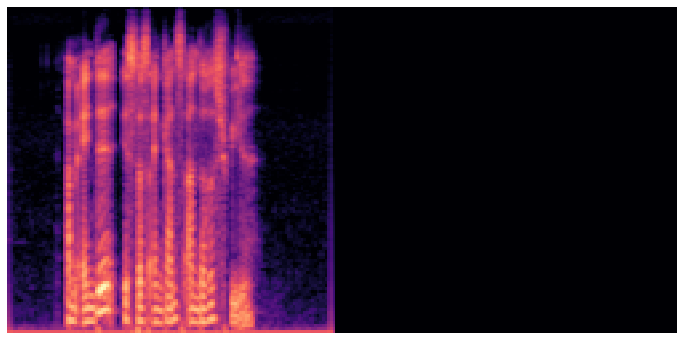

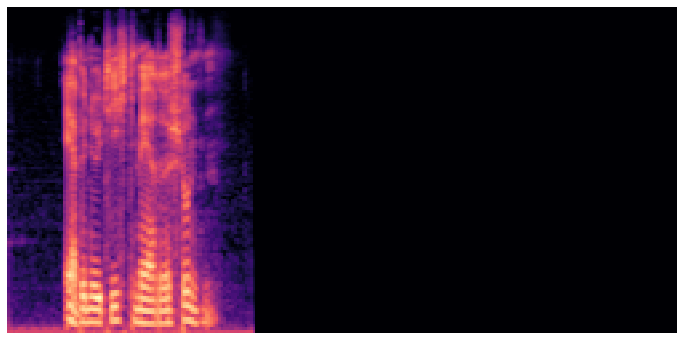

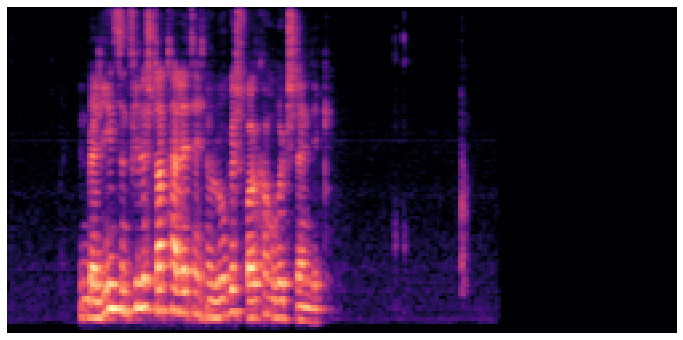

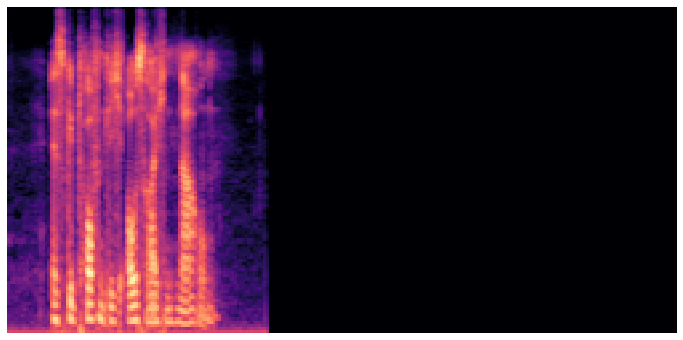

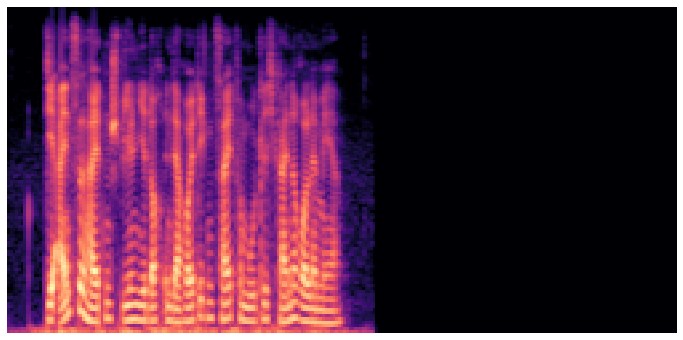

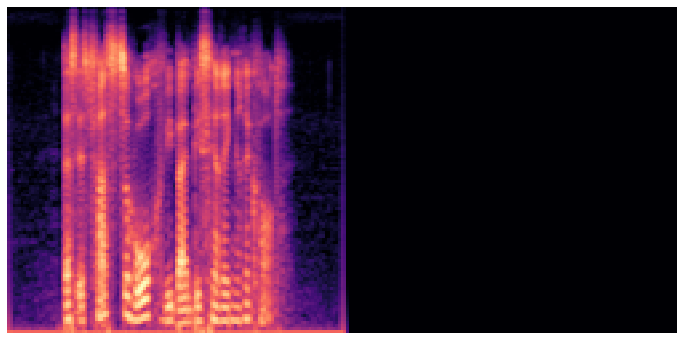

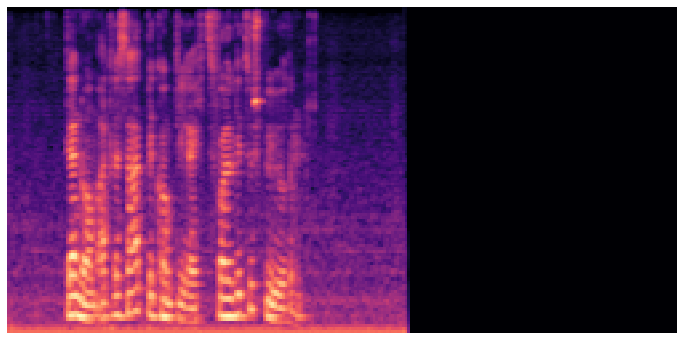

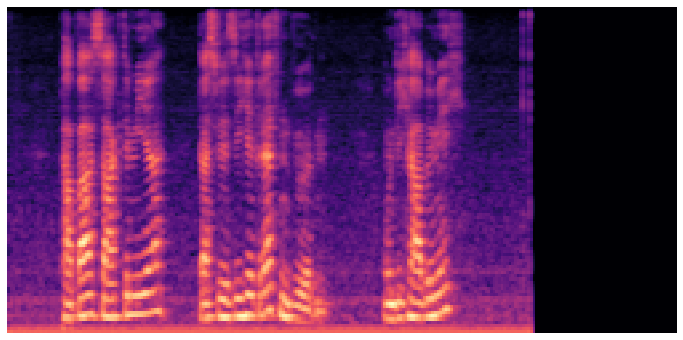

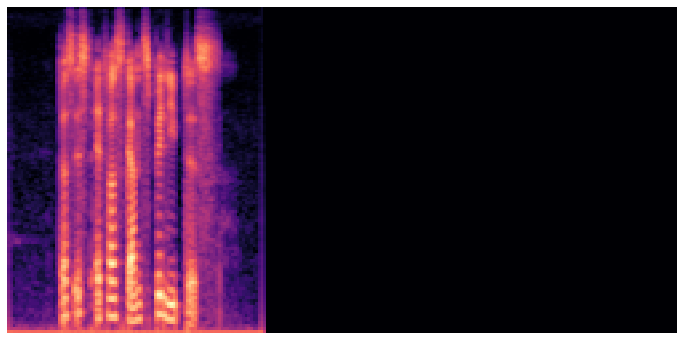

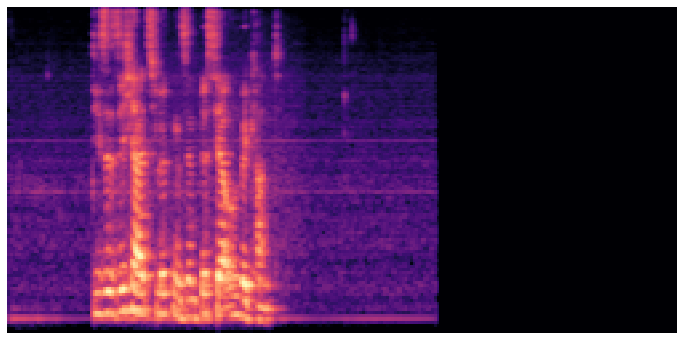

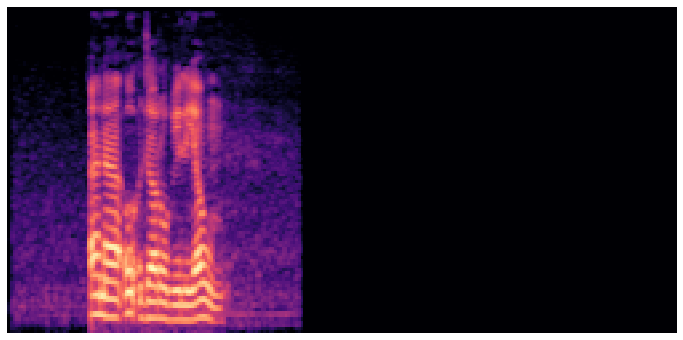

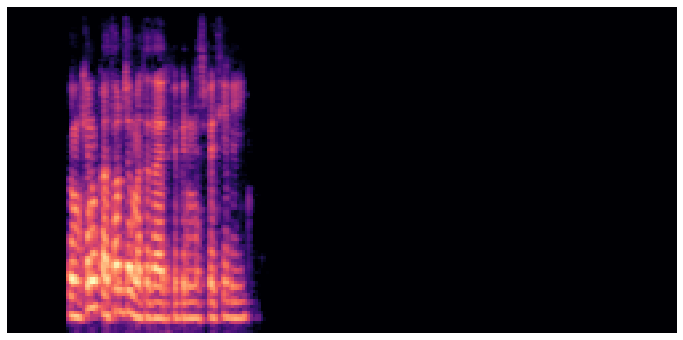

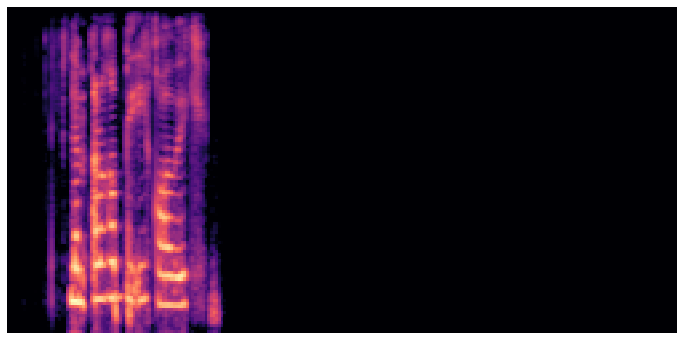

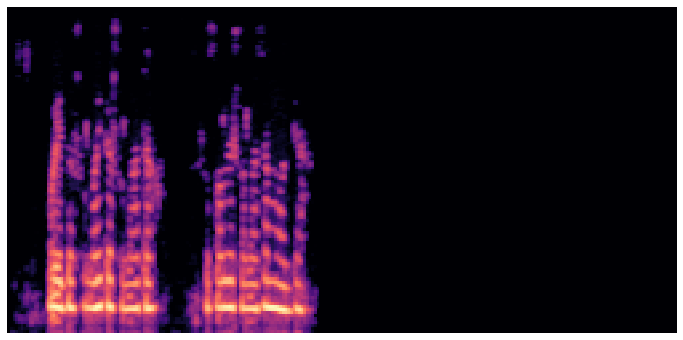

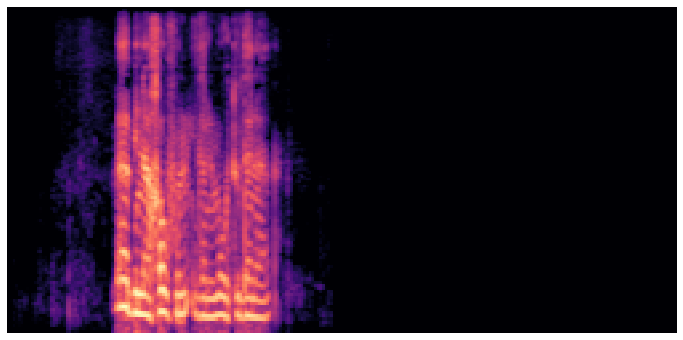

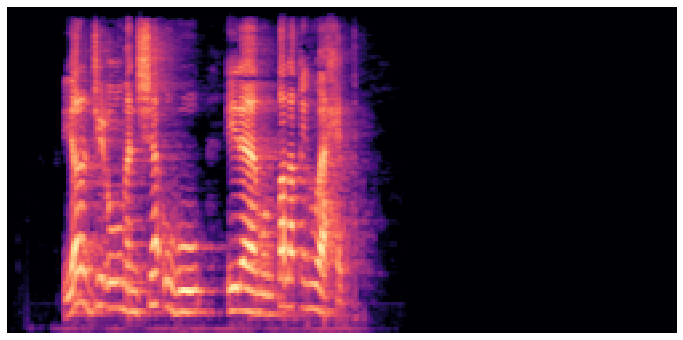

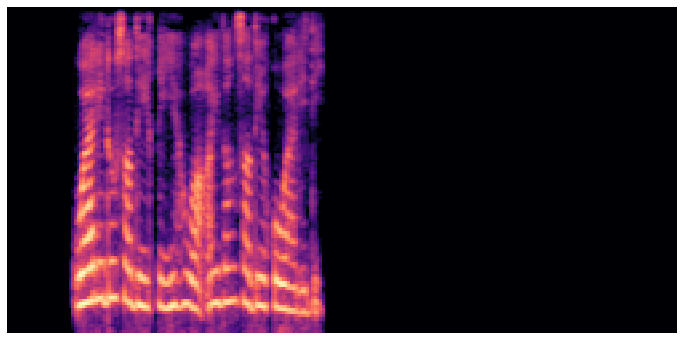

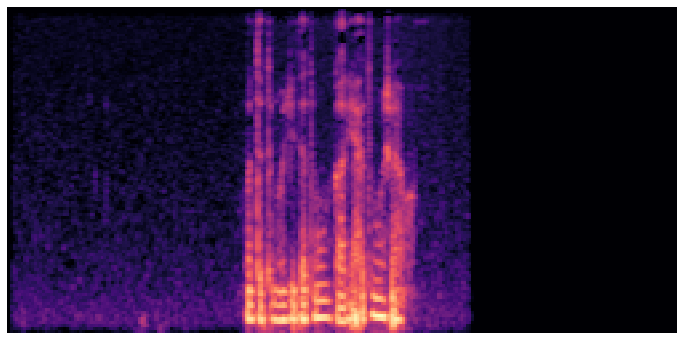

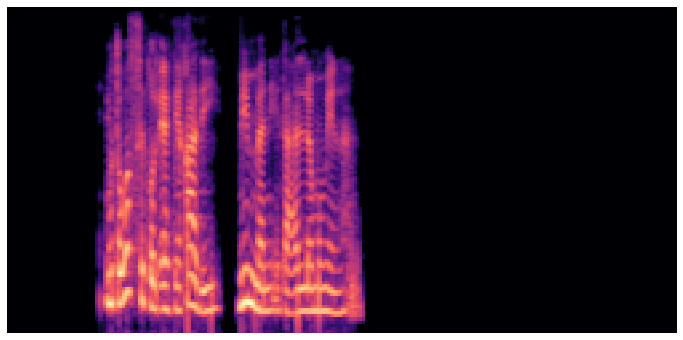

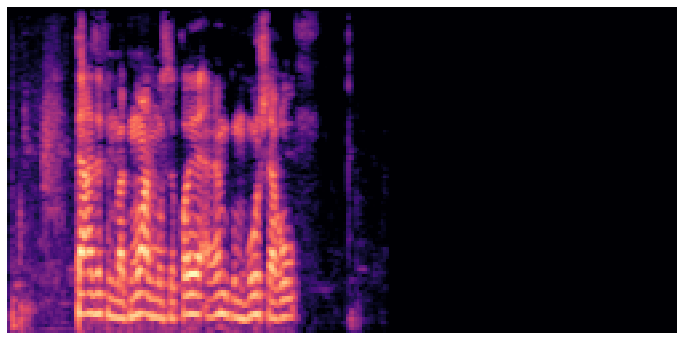

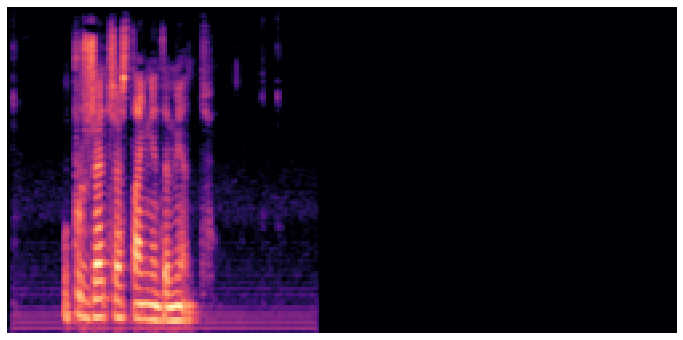

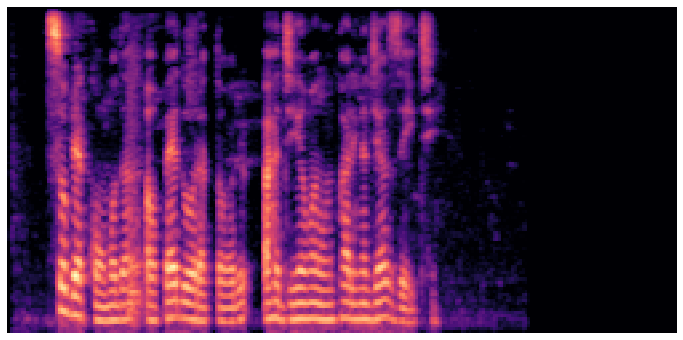

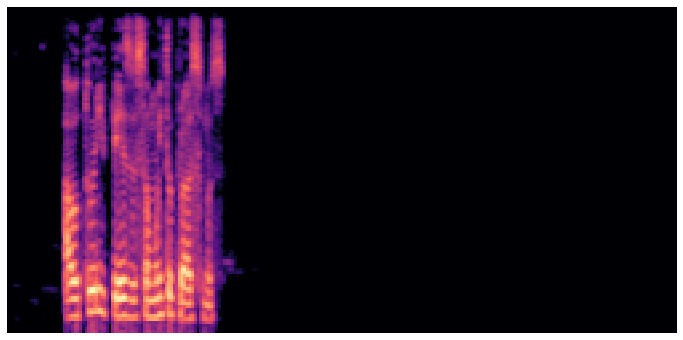

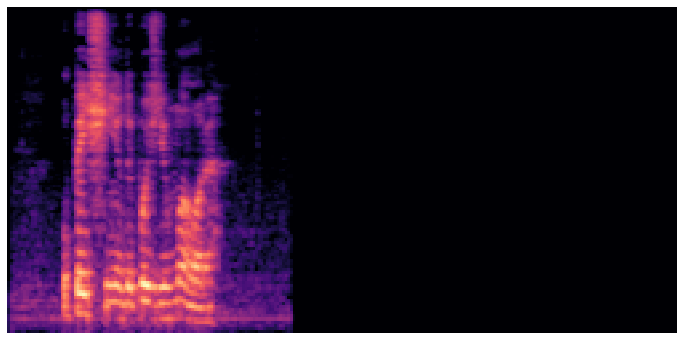

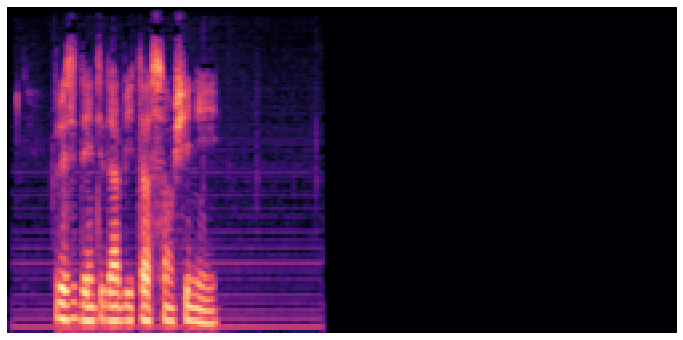

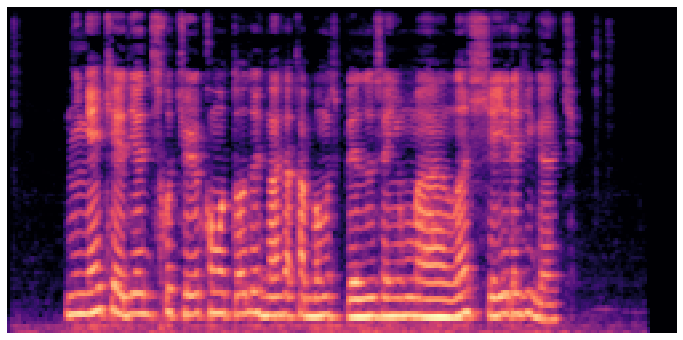

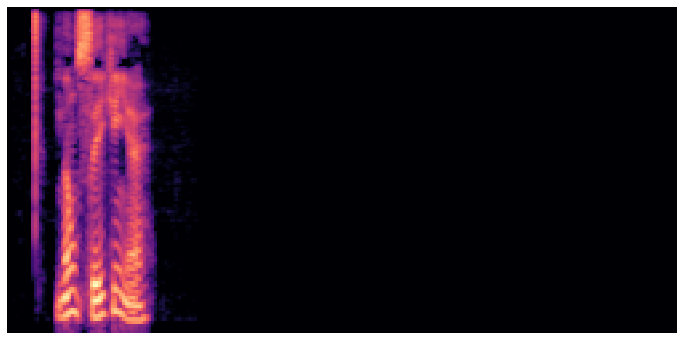

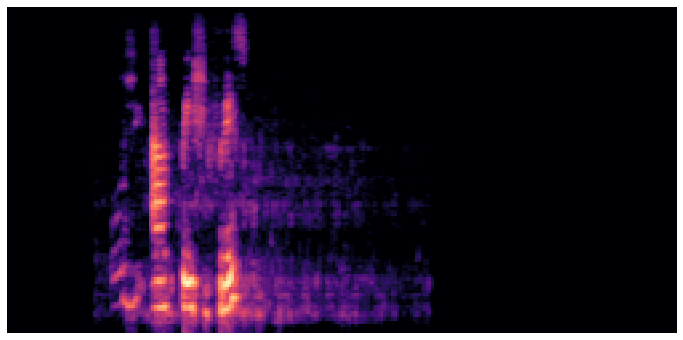

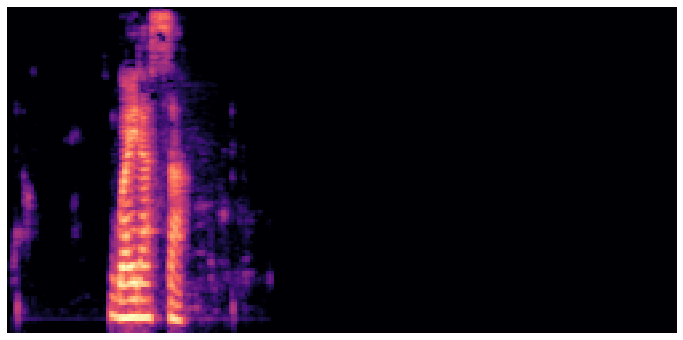

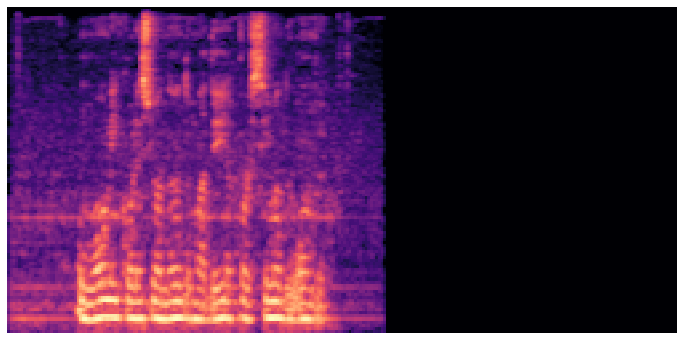

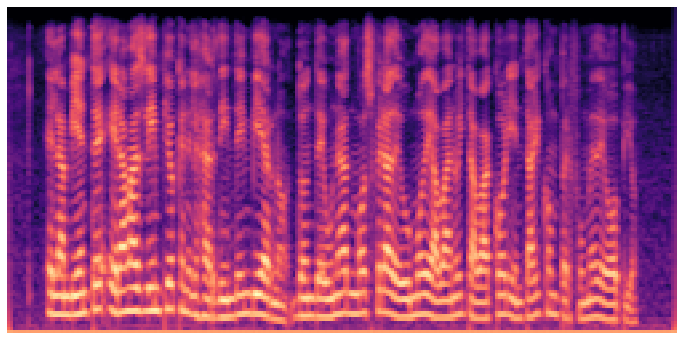

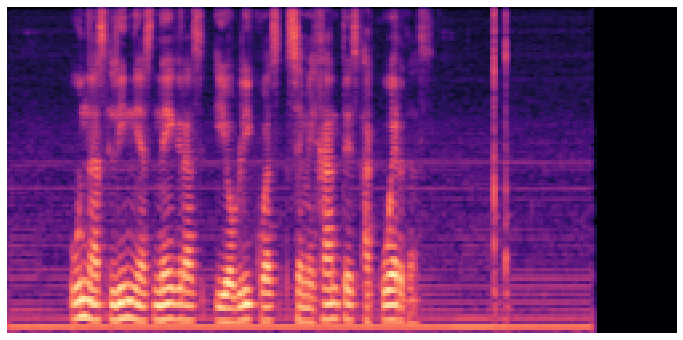

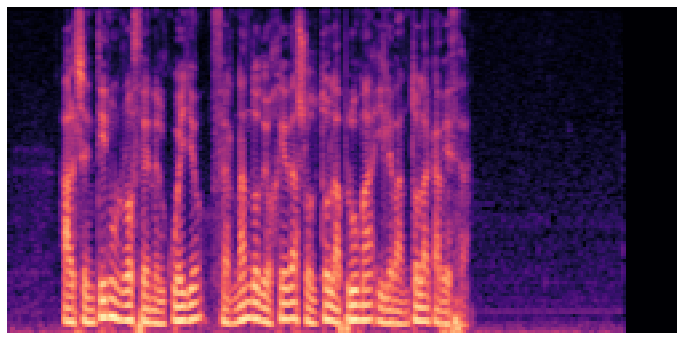

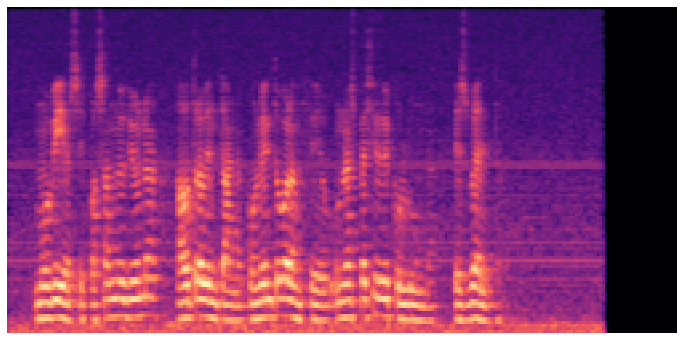

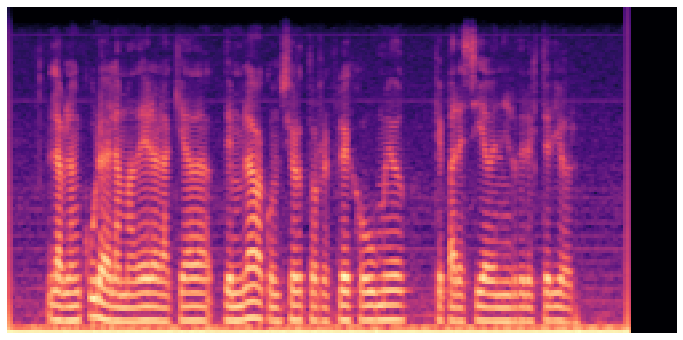

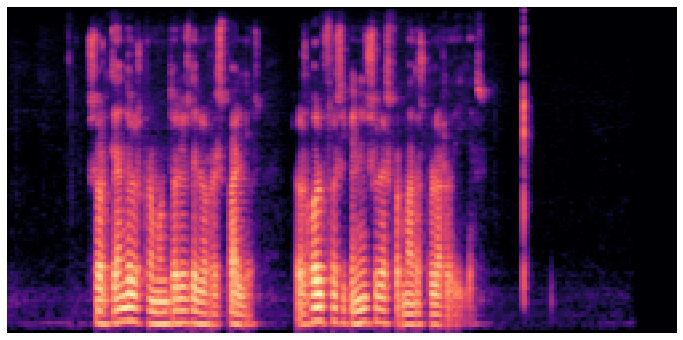

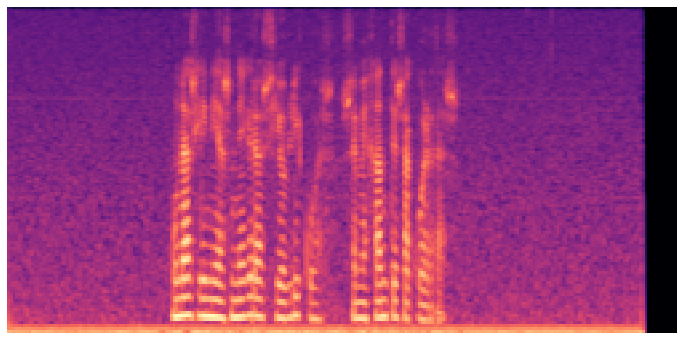

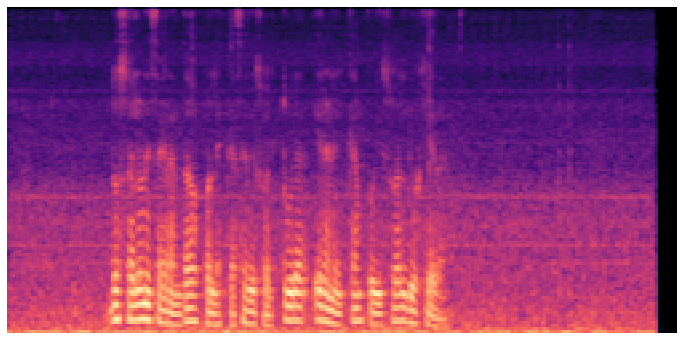

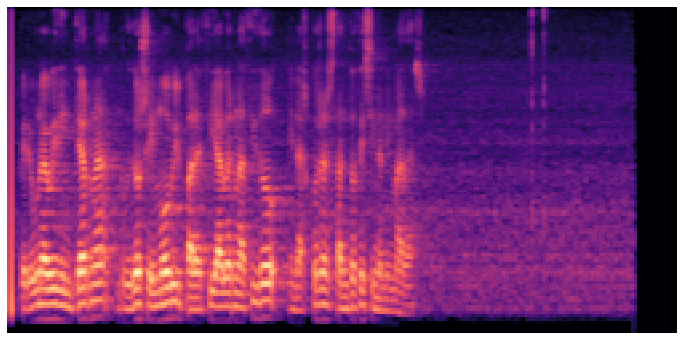

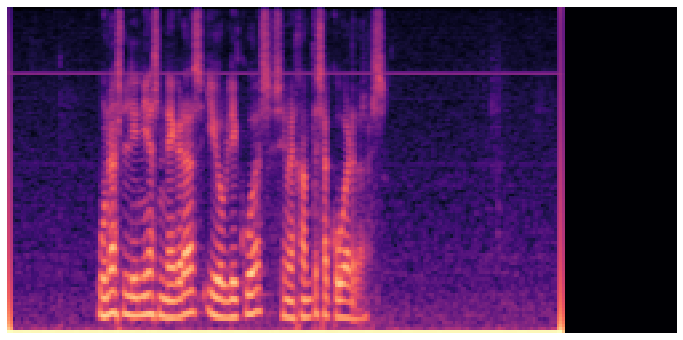

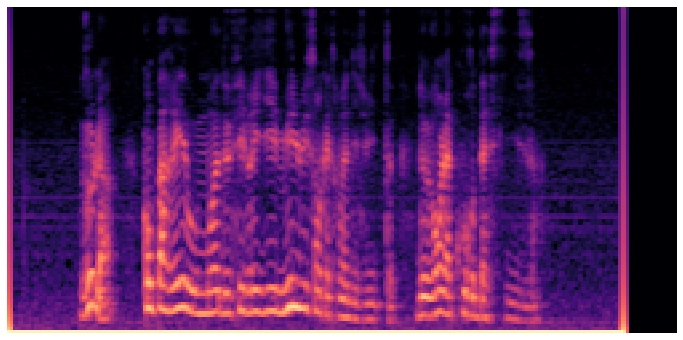

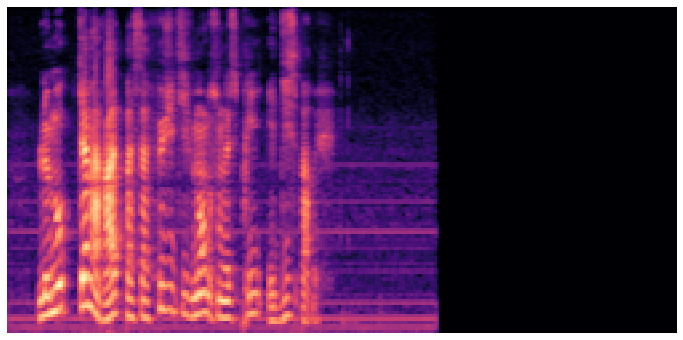

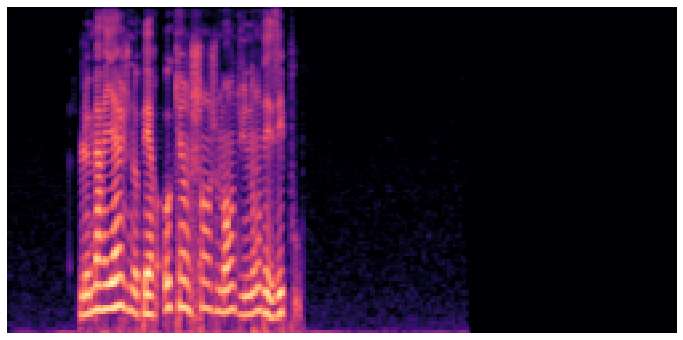

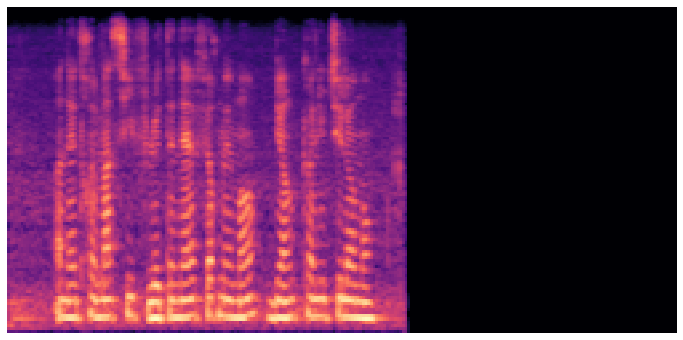

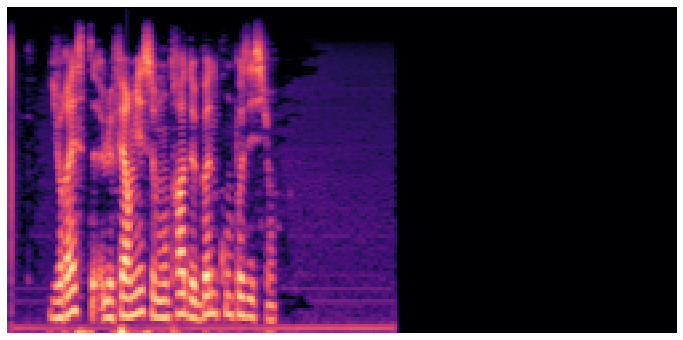

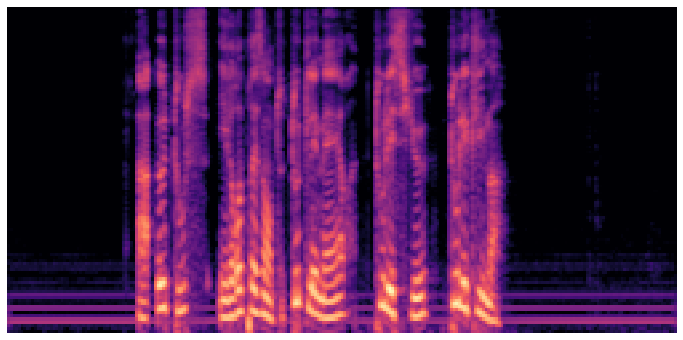

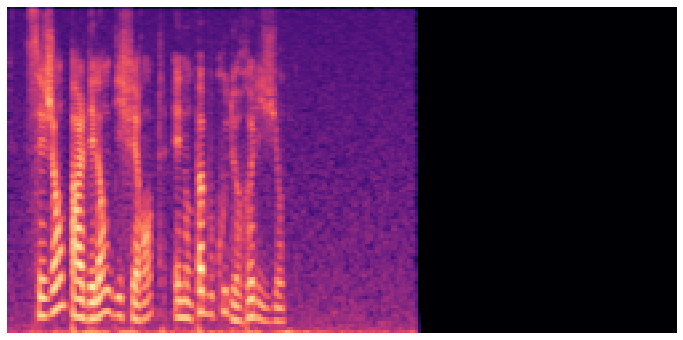

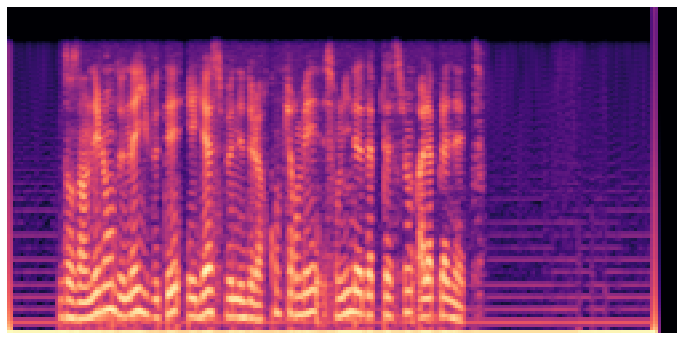

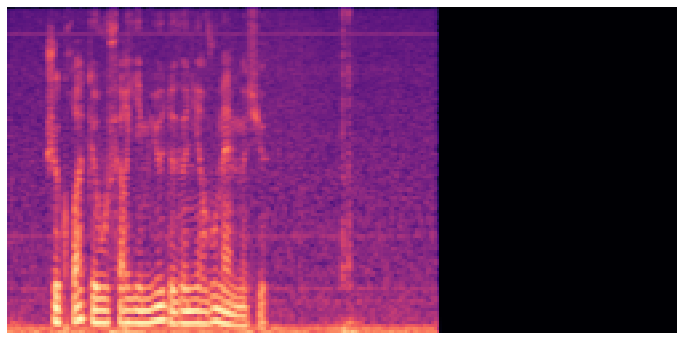

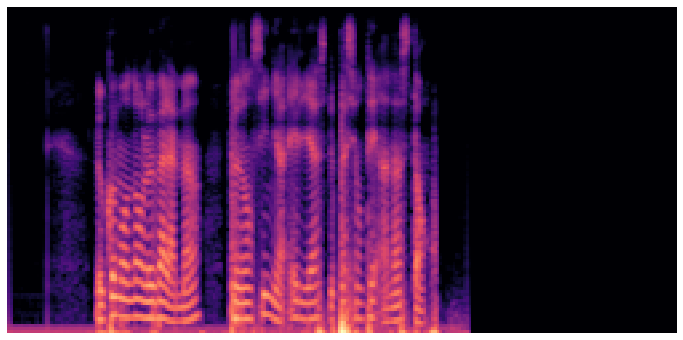

In [31]:
for File in Dataset["filename"].values:
    plt.figure(figsize=(12,6))

    y, sr = librosa.load(DataPath + File,duration = 8, sr=16000)
    y= librosa.util.fix_length(y, size=8*16000)

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=sr / 2.0)

    img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                                x_axis='time', y_axis='mel', fmax=sr / 2.0)

    plt.axis("off")
    plt.savefig(f"Test10IM/{File.split('.')[0]}.jpg")

In [19]:
y.shape

(60000,)

# Train model

In [28]:
import tensorflow as tf

In [29]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.optimizers import Adam


In [30]:
img_height = 224
img_width = 224
data_dir = "Test10IM"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode="categorical",
  seed=123,
  batch_size=32,

  image_size=(img_height, img_width))


Found 70 files belonging to 7 classes.
Using 56 files for training.


In [31]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

ds = train_ds
ds = ds.map(process)

In [32]:
ds

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [33]:
from keras import models, layers

In [34]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))

model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(7, activation="softmax"))

In [35]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 173056)           

In [43]:
opt = Adam(lr=0.001)
model3.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

hist = model3.fit(ds, validation_data=ds, epochs=10)

Epoch 1/10
2/2 [==============================] - 3s 1s/step - loss: 1.4527 - accuracy: 0.7500 - val_loss: 1.0987 - val_accuracy: 0.6607
Epoch 2/10
2/2 [==============================] - 3s 1s/step - loss: 0.9807 - accuracy: 0.7500 - val_loss: 0.4537 - val_accuracy: 0.8214
Epoch 3/10
2/2 [==============================] - 3s 1s/step - loss: 0.4609 - accuracy: 0.8214 - val_loss: 0.4491 - val_accuracy: 0.8393
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 0.5001 - accuracy: 0.8036 - val_loss: 0.4965 - val_accuracy: 0.8393
Epoch 5/10
2/2 [==============================] - 3s 1s/step - loss: 0.4850 - accuracy: 0.8571 - val_loss: 0.3632 - val_accuracy: 0.9464
Epoch 6/10
2/2 [==============================] - 3s 1s/step - loss: 0.3397 - accuracy: 0.9464 - val_loss: 0.2617 - val_accuracy: 0.9286
Epoch 7/10
2/2 [==============================] - 3s 1s/step - loss: 0.2458 - accuracy: 0.9643 - val_loss: 0.1506 - val_accuracy: 1.0000
Epoch 8/10
2/2 [=========================

In [37]:
model3.save("Model4.h5")

In [38]:
results = model3.evaluate(ds, batch_size=32)


2/2 [==============================] - 1s 168ms/step - loss: 1.0428 - accuracy: 0.6607


In [39]:
np.argmax(model3.predict(ds),axis=1)

2/2 [==============================] - 0s 154ms/step


array([2, 3, 0, 5, 3, 3, 5, 0, 2, 0, 0, 0, 5, 2, 0, 5, 5, 3, 3, 0, 0, 3,
       3, 5, 5, 2, 2, 2, 2, 5, 5, 2, 4, 0, 2, 2, 4, 0, 3, 2, 2, 3, 0, 0,
       0, 3, 0, 0, 0, 4, 5, 5, 0, 0, 0, 4], dtype=int64)

In [23]:
lang = [""]

<RangeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [44]:
y = np.concatenate([y for x, y in ds], axis=0)


array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
 

# Predict

In [47]:
lang = ["ar","de","en","es","fr","it","pt"]

In [67]:
onePopa = model3.predict(ds.take(1))[0]

1/1 [==============================] - 0s 336ms/step


In [69]:
lang[onePopa.argmax()]

'fr'